In [76]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from syclib.cluster import ClusterSC
from syclib import Matrix, SyntheticControl
import syclib.utils as utils

In [24]:
data = pd.read_csv("experiments/housing/hpi_clean_1996_2006.csv")
data = data.iloc[:, 4:] # use 10 years / 40 quarters of data, 1997 q1 to 2006 q4

In [25]:
data

,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43
0,105.36,105.39,108.51,109.22,109.44,108.05,110.66,111.64,112.31,113.55,114.57,115.67,114.23,113.72,115.41,117.63,118.65,120.12,118.82,123.25,122.51,121.51,123.33,126.81,126.36,127.04,127.78,126.19,129.99,132.13,133.43,134.53,136.74,142.10,142.65,144.99,150.50,151.24,155.18,157.85
1,110.93,111.93,114.16,115.37,117.42,118.45,119.75,121.23,122.30,123.51,123.76,124.05,124.14,125.89,128.02,129.38,132.16,133.42,134.45,136.33,136.77,137.00,138.85,139.85,140.75,141.61,143.00,143.23,144.55,145.47,146.21,147.59,148.92,150.21,151.73,152.09,152.59,150.01,149.10,151.13
2,109.48,110.14,111.34,114.63,113.97,114.30,116.85,116.27,118.22,116.94,118.60,120.86,122.45,121.32,122.75,122.26,126.06,126.70,127.57,127.78,128.14,130.13,131.61,133.12,132.72,135.98,135.76,139.45,139.09,139.93,141.29,143.61,144.08,148.75,149.44,155.59,154.71,159.07,157.99,161.70
3,115.31,116.09,118.36,120.77,121.71,123.72,122.93,125.47,124.56,125.57,125.20,126.01,125.04,125.21,124.00,128.02,130.60,131.42,129.85,132.17,132.79,129.48,133.26,134.31,134.71,135.46,135.59,137.66,137.63,140.16,145.11,144.34,146.43,152.97,159.91,164.00,172.33,176.11,182.00,185.65
4,100.03,100.40,99.87,100.95,102.87,101.80,102.29,103.39,103.72,104.01,104.12,103.00,104.13,105.29,107.44,107.63,108.85,111.19,113.65,114.59,115.76,118.48,121.15,124.15,126.06,128.59,132.50,137.99,140.88,146.18,155.07,158.21,162.29,170.18,177.01,179.36,183.81,187.49,187.90,190.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,109.64,109.63,109.62,110.93,112.76,113.20,114.43,115.54,116.31,116.59,115.22,116.16,114.09,116.39,116.48,118.69,121.59,123.06,121.29,122.73,124.59,122.94,124.15,126.22,127.03,127.73,128.47,129.18,131.70,132.59,133.63,134.85,137.48,139.10,142.73,143.75,148.57,152.89,154.90,159.51
396,105.48,106.53,107.43,108.29,110.38,110.41,110.76,111.68,112.70,112.68,111.31,112.47,110.79,113.12,113.62,113.98,117.93,118.63,119.10,119.98,121.08,121.33,123.36,124.61,125.71,127.42,129.74,132.96,134.35,137.35,144.15,146.74,150.63,157.20,164.04,169.80,174.41,178.06,181.32,183.81
397,112.08,115.20,116.05,118.35,119.52,121.08,122.94,124.10,123.82,125.56,124.71,123.26,125.08,125.84,127.49,128.89,132.51,133.09,134.25,136.37,136.47,137.73,138.83,139.97,141.10,141.84,142.87,143.86,147.15,144.94,147.01,147.38,149.00,150.33,152.45,150.86,152.40,150.69,151.22,150.67
398,99.19,97.81,98.26,101.44,103.54,101.47,100.70,103.33,104.59,104.99,103.35,106.55,106.38,109.11,111.80,114.11,118.12,123.26,126.44,128.56,132.57,136.67,144.54,150.10,154.91,160.61,166.84,179.66,186.10,196.40,210.99,223.92,236.63,255.12,265.23,277.32,276.22,270.83,271.70,264.08


# Matrix class

In [56]:
T0 = 36
target_id = 0
M = Matrix(data.T, T0, target_name=target_id)

In [57]:
# automatically partitions data into pre_donor, post_donor, pre_target, post_target. For example:
M.post_donor

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399
40,152.59,154.71,172.33,183.81,160.59,167.37,190.07,153.31,151.38,163.03,334.93,191.16,185.18,157.44,156.94,206.25,177.82,176.31,263.44,175.53,158.13,167.67,270.67,240.37,188.15,309.31,168.60,177.26,175.57,151.17,210.16,262.87,176.71,154.97,166.62,165.25,179.46,141.70,152.92,172.21,...,157.22,225.97,228.21,155.59,164.04,162.72,156.89,183.46,148.55,165.05,315.01,146.91,203.45,235.18,242.62,154.30,175.34,149.12,177.84,274.29,186.30,172.40,160.89,164.34,159.76,313.62,147.66,145.16,148.09,153.89,206.05,204.58,252.95,151.36,243.04,148.57,174.41,152.40,276.22,228.05
41,150.01,159.07,176.11,187.49,166.97,170.61,193.99,157.91,155.26,163.97,340.12,195.81,181.82,161.12,155.58,213.64,177.83,176.67,270.20,175.54,159.98,173.17,276.33,244.93,187.28,306.54,173.30,176.78,169.21,152.95,216.99,285.49,181.14,157.50,168.43,170.49,188.47,144.34,151.41,173.93,...,158.49,227.62,234.99,155.69,168.54,172.38,162.04,186.07,153.62,170.01,315.33,150.68,205.13,241.86,248.67,154.09,185.16,151.34,174.83,278.67,188.24,180.33,163.38,161.39,167.31,317.50,151.19,147.44,148.37,155.65,208.34,215.23,257.37,152.41,241.81,152.89,178.06,150.69,270.83,231.50
42,149.10,157.99,182.00,187.90,172.89,176.92,196.27,161.68,157.91,162.35,339.56,199.80,180.11,163.54,156.97,220.18,179.64,177.65,274.53,179.28,163.56,176.74,279.35,248.52,189.89,301.93,177.70,175.29,169.76,155.42,220.73,295.82,182.70,161.89,170.59,174.60,193.66,144.43,155.34,171.21,...,160.14,229.57,237.36,157.39,170.08,177.85,162.57,190.46,152.04,172.42,312.38,154.05,209.15,245.56,249.26,157.41,192.48,151.77,172.70,279.90,190.94,186.55,163.55,165.47,179.17,316.50,148.69,149.33,151.30,159.73,211.03,218.96,252.05,152.96,238.09,154.90,181.32,151.22,271.70,234.30
43,151.13,161.70,185.65,190.15,176.25,178.62,198.60,160.67,157.43,164.48,337.62,200.33,181.00,165.90,158.27,223.38,182.95,180.60,276.00,186.10,166.55,180.30,280.10,251.98,195.98,301.67,180.85,175.70,172.43,160.43,220.29,297.42,186.59,165.29,172.97,174.56,195.55,146.48,154.91,175.27,...,160.34,229.60,237.70,158.87,170.85,182.27,163.24,188.19,158.13,178.06,310.10,152.05,212.62,249.49,247.82,153.56,195.53,152.05,172.75,281.95,193.16,192.80,164.62,166.25,187.32,314.42,152.81,149.18,152.95,157.09,214.23,222.78,254.78,154.75,239.76,159.51,183.81,150.67,264.08,238.06


In [33]:
M.post_target

,0
40,150.50
41,151.24
42,155.18
43,157.85


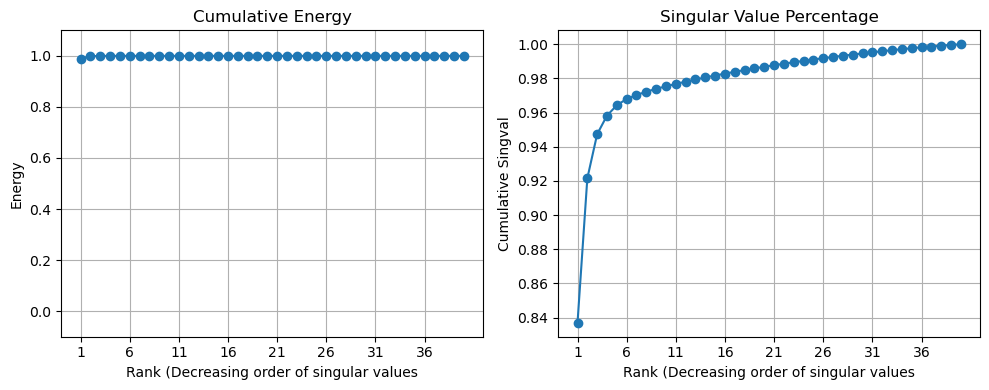

approx rank: 4


In [55]:
# get approx rank of data
s = utils.singval_test(data, data.shape[0])
r = utils.get_approx_rank(s, threshold=0.95)
print("approx rank:", r)

In [ ]:
# perform hsvt with approx rank
M.denoise(num_sv=4)
M.post_donor

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399
40,149.658712,154.992728,170.924598,185.091573,162.074891,169.137224,190.982731,155.664611,152.487139,161.955959,336.072815,192.534468,183.341512,158.512635,155.634749,209.985910,177.499548,175.798520,267.683682,175.111093,157.880563,169.232367,271.233385,242.450210,188.937965,311.194216,168.736912,175.232060,171.540220,150.644583,213.029593,267.617981,179.010737,155.489923,166.516719,167.360782,185.977339,142.024560,151.433132,169.633982,...,157.596815,227.480124,227.122218,154.430020,164.500363,165.999932,158.338800,182.929256,150.323639,166.982912,314.748281,147.509695,201.904681,237.386252,242.168378,153.353272,181.016445,148.054969,175.089369,276.048032,188.518999,176.903316,162.513764,162.970951,164.426941,310.490464,148.180230,145.808881,147.375970,153.264272,206.922093,204.960828,250.955919,149.913741,243.510836,148.810265,174.216002,149.938171,275.066823,224.773909
41,150.260860,157.339750,176.783686,186.553479,167.104139,171.985767,193.503100,157.389960,154.639453,162.800422,338.054909,195.677668,182.435799,160.510587,156.401763,214.126013,178.350528,177.123775,270.553323,177.969472,160.640431,173.489649,276.936946,245.816825,189.495075,305.220819,172.929907,175.614788,171.298659,152.975945,216.978065,280.369167,181.001173,158.917796,168.599576,169.910100,188.885801,143.337084,152.508910,171.783157,...,158.425333,227.792864,234.153865,155.886321,167.052886,171.742861,159.840053,186.380174,151.794664,170.163364,315.282919,149.699822,206.400377,242.637473,248.017784,154.229729,185.060696,149.752540,174.798702,279.293360,189.618555,182.141005,163.062125,163.583144,170.929173,315.338333,149.148744,147.032162,149.157367,154.940994,209.221356,213.236744,254.562189,151.918702,240.589369,152.056677,178.276985,150.447600,273.579628,233.261622
42,151.514307,159.696516,181.550845,187.735141,171.191027,174.351171,195.315053,159.132414,156.641292,164.054427,337.034090,197.998452,181.924337,162.489995,157.526064,216.739335,179.149480,178.154219,271.452882,180.366830,163.145691,176.110486,279.849916,247.435549,190.050215,298.653286,176.237514,176.488046,171.701470,155.210244,219.564221,287.606578,182.699576,161.641979,170.554493,172.168443,190.913360,145.102409,154.119678,173.991895,...,159.599606,227.247682,238.464504,157.372087,169.534249,176.399826,161.491588,188.681744,153.208636,172.965509,313.019636,152.086665,209.502917,245.728632,251.614902,155.409922,188.147932,151.760694,175.010508,280.064014,190.427771,185.877054,164.021014,164.619263,175.948567,316.913024,150.510054,148.614617,151.185005,156.916508,210.579156,219.092933,256.366347,153.999106,237.432450,155.147914,181.533305,151.765637,271.405758,238.724906
43,153.667611,162.278455,185.472393,188.723265,174.386621,176.975235,196.771021,161.296431,159.036412,166.095224,335.388231,199.987096,183.046519,164.782676,159.390102,219.178699,180.831326,180.056434,271.594963,182.759857,165.652481,179.103757,280.607969,248.194604,190.967819,294.663943,179.361915,178.419298,173.459873,157.714085,221.136472,291.892335,184.480484,164.188449,172.814003,174.468594,193.003794,147.426203,156.197950,176.309736,...,161.467915,227.012972,241.154727,159.618090,172.195888,180.171795,163.541256,189.855633,154.842506,175.671219,311.005871,154.724621,211.586153,247.411539,253.194327,157.224005,190.523796,154.168260,176.708515,279.947505,192.161274,188.592105,165.762518,166.582625,179.714184,316.853639,152.475331,150.877227,153.517170,159.147588,211.668651,223.262758,257.088339,156.557049,235.993831,158.137296,184.133592,153.963193,269.212840,241.922763


# Synthetic Control Class

In [59]:
sc = SyntheticControl()
sc.fit(M.pre_donor, M.pre_target, method='ols')

In [70]:
# train counterfactual:
pred_train = sc.predict(M.pre_donor).T
pred_train

,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,105.663627,106.39019,107.485893,108.56353,109.895073,110.455131,111.481498,112.222465,112.794731,113.409233,113.565483,113.768364,114.464409,115.105278,116.067436,116.918266,119.077202,119.861625,120.693413,121.689262,122.302788,122.713676,124.052788,124.95977,125.711723,126.450737,127.563774,128.770805,129.757866,131.200981,133.013237,134.693413,136.337211,139.499565,142.551811,145.093315


In [71]:
# test counterfactual:
pred_test = sc.predict(M.post_donor).T
pred_test

,40,41,42,43
0,147.531303,150.115288,152.547905,154.811088


In [80]:
# mses:
print("train loss (mse):", mean_squared_error(M.pre_target, pred_train.T))
print("test loss (mse):", mean_squared_error(M.post_target, pred_test.T))

train loss (mse): 1.237231518486991
test loss (mse): 6.560262166031599


Note that this is only for one target without train/test splitting; see the experiment code for the leave-one-out test.

# ClusterSC

In [82]:
donor_data = data.drop(index=[target_id]) # drop target from data before clustering
csc = ClusterSC(donor_data)
csc.perform_clustering(k=2, random_state=0, method="kmeans")

In [95]:
# cluster 1
c1 = csc.get_donor_group(0)
c1_rank = utils.get_approx_rank(utils.singval_test(c1, c1.shape[0], show=False), threshold=0.95)
print(c1_rank)
c1

3


,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43
1,110.93,111.93,114.16,115.37,117.42,118.45,119.75,121.23,122.30,123.51,123.76,124.05,124.14,125.89,128.02,129.38,132.16,133.42,134.45,136.33,136.77,137.00,138.85,139.85,140.75,141.61,143.00,143.23,144.55,145.47,146.21,147.59,148.92,150.21,151.73,152.09,152.59,150.01,149.10,151.13
2,109.48,110.14,111.34,114.63,113.97,114.30,116.85,116.27,118.22,116.94,118.60,120.86,122.45,121.32,122.75,122.26,126.06,126.70,127.57,127.78,128.14,130.13,131.61,133.12,132.72,135.98,135.76,139.45,139.09,139.93,141.29,143.61,144.08,148.75,149.44,155.59,154.71,159.07,157.99,161.70
3,115.31,116.09,118.36,120.77,121.71,123.72,122.93,125.47,124.56,125.57,125.20,126.01,125.04,125.21,124.00,128.02,130.60,131.42,129.85,132.17,132.79,129.48,133.26,134.31,134.71,135.46,135.59,137.66,137.63,140.16,145.11,144.34,146.43,152.97,159.91,164.00,172.33,176.11,182.00,185.65
4,100.03,100.40,99.87,100.95,102.87,101.80,102.29,103.39,103.72,104.01,104.12,103.00,104.13,105.29,107.44,107.63,108.85,111.19,113.65,114.59,115.76,118.48,121.15,124.15,126.06,128.59,132.50,137.99,140.88,146.18,155.07,158.21,162.29,170.18,177.01,179.36,183.81,187.49,187.90,190.15
5,106.35,106.60,107.22,108.69,109.18,108.77,109.15,109.96,109.50,109.27,108.95,108.87,109.37,109.13,110.06,110.56,113.07,114.02,114.48,115.36,115.81,116.82,118.36,119.13,120.32,121.59,122.48,124.88,126.32,128.73,132.05,134.36,137.00,144.05,150.12,154.80,160.59,166.97,172.89,176.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,108.06,109.08,111.17,112.49,114.04,114.56,116.37,117.92,118.16,119.32,119.84,120.66,121.50,123.19,125.04,126.02,128.97,129.44,130.70,132.07,132.57,132.86,134.66,135.64,136.47,137.02,137.22,138.99,139.30,139.92,140.47,142.50,144.46,145.83,147.76,149.99,151.36,152.41,152.96,154.75
395,109.64,109.63,109.62,110.93,112.76,113.20,114.43,115.54,116.31,116.59,115.22,116.16,114.09,116.39,116.48,118.69,121.59,123.06,121.29,122.73,124.59,122.94,124.15,126.22,127.03,127.73,128.47,129.18,131.70,132.59,133.63,134.85,137.48,139.10,142.73,143.75,148.57,152.89,154.90,159.51
396,105.48,106.53,107.43,108.29,110.38,110.41,110.76,111.68,112.70,112.68,111.31,112.47,110.79,113.12,113.62,113.98,117.93,118.63,119.10,119.98,121.08,121.33,123.36,124.61,125.71,127.42,129.74,132.96,134.35,137.35,144.15,146.74,150.63,157.20,164.04,169.80,174.41,178.06,181.32,183.81
397,112.08,115.20,116.05,118.35,119.52,121.08,122.94,124.10,123.82,125.56,124.71,123.26,125.08,125.84,127.49,128.89,132.51,133.09,134.25,136.37,136.47,137.73,138.83,139.97,141.10,141.84,142.87,143.86,147.15,144.94,147.01,147.38,149.00,150.33,152.45,150.86,152.40,150.69,151.22,150.67


In [96]:
# cluster 2
c2 = csc.get_donor_group(1)
c2_rank = utils.get_approx_rank(utils.singval_test(c2, c2.shape[0], show=False), threshold=0.95)
print(c2_rank)
c2

4


,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43
11,100.79,101.45,103.50,105.40,108.21,111.78,116.04,118.84,120.62,123.07,126.21,128.18,132.99,136.22,139.76,143.55,146.84,150.79,155.03,158.15,163.20,170.30,176.78,181.89,186.90,191.32,198.51,213.39,222.57,238.28,264.12,271.96,279.92,295.07,308.97,324.17,334.93,340.12,339.56,337.62
19,105.29,105.96,107.42,108.70,111.39,111.80,113.80,114.66,114.54,113.99,116.14,117.35,120.08,121.01,127.14,126.32,131.88,133.25,136.47,138.97,143.02,146.67,151.27,155.43,159.90,163.25,169.49,179.43,185.98,193.65,207.51,214.87,222.78,238.01,248.05,257.87,263.44,270.20,274.53,276.00
23,98.85,98.15,99.03,101.63,103.59,102.63,103.69,104.63,104.54,103.78,105.13,102.79,104.22,104.98,107.44,109.24,111.92,114.06,115.79,117.65,119.74,123.35,126.96,130.38,133.95,138.17,144.30,152.86,159.51,170.17,189.95,201.62,215.36,230.39,245.91,260.81,270.67,276.33,279.35,280.10
24,104.88,104.13,105.43,106.61,108.14,107.99,108.79,109.79,110.92,111.47,112.14,113.54,115.33,116.64,118.81,120.23,123.01,125.38,128.20,130.06,133.29,137.47,141.31,144.08,147.03,150.23,154.65,163.27,167.95,175.38,187.54,194.33,202.76,214.28,225.49,233.51,240.37,244.93,248.52,251.98
26,106.43,108.58,110.19,111.61,112.94,114.70,118.01,120.14,123.19,128.48,133.44,140.56,145.34,152.96,159.57,164.11,168.94,175.17,182.00,186.87,194.93,204.21,212.39,217.96,224.19,229.86,235.42,249.01,256.37,266.08,278.27,283.76,292.63,299.29,303.97,307.42,309.31,306.54,301.93,301.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,102.79,102.37,103.33,104.11,105.59,105.73,106.28,107.46,108.69,109.52,111.45,113.10,115.69,119.38,122.31,125.10,129.20,133.05,137.20,140.24,143.91,149.17,154.24,157.10,160.04,163.19,168.35,177.31,182.84,192.31,209.76,217.45,227.49,244.50,257.78,268.98,274.29,278.67,279.90,281.95
385,105.65,105.05,106.55,108.02,110.14,110.60,112.00,112.92,113.31,114.11,116.50,118.13,120.98,123.11,125.84,128.60,131.48,135.11,138.80,142.80,146.42,152.18,157.76,161.74,166.51,171.96,176.48,186.86,195.27,205.78,222.75,234.03,248.79,267.97,285.96,299.04,313.62,317.50,316.50,314.42
392,105.79,105.17,107.78,110.13,110.08,109.53,110.54,111.44,111.73,113.00,111.46,113.12,115.98,117.45,118.07,120.74,122.69,126.25,128.98,129.63,132.45,136.20,140.71,142.99,146.10,148.47,153.99,160.81,169.02,175.05,189.17,196.44,209.04,222.74,236.24,244.07,252.95,257.37,252.05,254.78
394,106.81,107.96,108.86,110.47,112.13,113.36,115.80,117.01,118.87,122.17,125.71,127.86,133.29,137.12,141.61,144.80,148.65,153.09,158.74,162.84,166.89,173.31,178.70,182.90,186.65,189.94,193.82,201.59,205.11,210.56,220.06,224.56,229.14,234.92,239.68,241.49,243.04,241.81,238.09,239.76


In [114]:
target_data = data.loc[[target_id]]
target_pre = target_data.iloc[:, :T0]
target_pre

,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,105.36,105.39,108.51,109.22,109.44,108.05,110.66,111.64,112.31,113.55,114.57,115.67,114.23,113.72,115.41,117.63,118.65,120.12,118.82,123.25,122.51,121.51,123.33,126.81,126.36,127.04,127.78,126.19,129.99,132.13,133.43,134.53,136.74,142.1,142.65,144.99


In [117]:
pred_cluster = csc.predict_target_cluster(target_pre.T)
print(pred_cluster)

0


In [121]:
# therefore selected donors are c1
cluster_dataset = pd.concat([target_data, c1], axis=0) # append target data to cluster 1
M = Matrix(cluster_dataset.T, T0=T0, target_name=target_id)
M.denoise(num_sv=c1_rank)
cluster_SC = SyntheticControl()
cluster_SC.fit(M.pre_donor, M.pre_target, method='ols')

In [125]:
# mses:
print("train loss (mse):", cluster_SC.predict_and_mse(M.pre_donor, M.pre_target))
print("test loss (mse):", cluster_SC.predict_and_mse(M.post_donor, M.post_target))

train loss (mse): 1.1800474104455856
test loss (mse): 6.089123161663724
